# 771948_A23_T3A - Group Work Assignment #
# Task 2 - Multi-label image-based digit classification problem #
## Assignment by CM 202369825 and AA 202375309 ##

---
### Additional notes from class chat ###
#### 1. Labels from dataset will be folder names
#### 2. Beware of the multi image model classifying into triplets instead of single digits. The output shape should be 1000 instead of 10
#### 3. DO NOT recombine the split data. It has to be used as is as per TA Khadjia
#### 4. From Khadjia: The provided splits into training, validation and testing were designed to simulate real-world scenarios. Teams must develop a baseline model using these splits and gthen improve upon this baseline through various techniques such as preprocessing and model architecture enhancements.
---

# Task 6 - Load and preprocess the dataset for multi-label image-based digit classification task

## <b>References</b>

Johns, Ray. (2024). PyTorch vs TensorFlow for your Python Deep Learning Project. Available at: https://realpython.com/pytorch-vs-tensorflow/. [Accessed Aug 5, 2024]

In [2]:
# For this assignment we have chosen to use the TensorFlow over PyTorch as TensorFlow 2.0 has eager execution and the Keras APIs have more prefabricated components for us to use.
import tensorflow as tf
from tensorflow import keras
# Needed for image pre-processing
from PIL import Image
import os
# there is a lint problem access problem with the latest release of TensorFlow/Keras so we have to go direct to the root call
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, Input
# we want these for some visualizations
import matplotlib.pyplot as plt
import numpy as np
# for progress bars
from tqdm import tqdm

# Change directory location as needed. This should be the root of the unzipped dataset and the initial folder visible shuold be "triple_mnist" 
# -------------------------------------------
dataset_root_dir = 'z:'
log_dir = dataset_root_dir + '\\logs'
# -------------------------------------------

# set this to true for overnight detailed training results
# -------------------------------------------
extreme_training = True
long_hyperp_training = False
# -------------------------------------------

# Set the number of epochs to train for
planned_epochs = 20
if extreme_training is False:
    planned_epochs = 5


# Set the random seed for reproducibility
tf.random.set_seed(42)

# Define our data split directory locations
training_dir = dataset_root_dir + '\\triple_mnist\\train'
validate_dir = dataset_root_dir + '\\triple_mnist\\val'
test_dir = dataset_root_dir + '\\triple_mnist\\test'

# mode switch for label encoding tests
# class_mode_default = 'categorical' # or sparse
class_mode_default = 'sparse' # or categorical
#loss_mode_default = 'categorical_crossentropy' # or sparse_categorical_crossentropy
loss_mode_default = 'sparse_categorical_crossentropy' # or categorical_crossentropy


# Define our image parameters
image_height = 84
image_width = 84
batch_size = 32
# these are grayscale images, so we will only have 1 channel and this will be enforced in the data loading process
channels = 1
# output classes will be 0 to 9 which = 10
num_classes = 10

# Data augmentation and preprocessing parameters to initialize the ImageDataGenerator
# Transformations we are NOT using include: zoom_range, horizontal_flip, vertical_flip, fill_mode, channel_shift_range, brightness_range, zca_epsilon, zca_whitening
# Note that we had the opportunity to use the "preprocessing_function" parameter to crop the images as needed but we chose to persist the cropped images to disk to prevent
# this function from being called with each epoch. This is because the cropping function is computationally expensive and we only need to do it once.
idg = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0, 1]
    shear_range=0.2,         # Apply shear transformations
    rotation_range=40,       # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,   # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,   # Randomly shift images vertically by up to 20% of the height
)

## Pre-processing to get the triplet digit data into single values
### The data came to us as a series of triplet hand written numbers meaning that in the 84 x 84 image there are three images. Upon inspection there is a clean divide between all digits despite them having random y placement in the frame. Our best approach is to take the file name, divide the image into three and then save out the single hand written digit to a new folder. To manage this in memory could be costly so we will check if the images exist on your disk, write them if necessary, but read them from pre-processesd state if they have already been cleaned in your local dataset. We will watch for images that get cropped but even that might be only a couple of pixels.

In [3]:
# --------------------------------------------------------------------------
# this is the function that will crop a triplet digit image into three separate images and return them as a list of three images.
# this function does not manage disk persistence, it is only for in-memory processing
def crop_image(image):
    image_return = []
    x_cropsize = 28
    y_cropsize = 84
    x_croplength = x_cropsize/2
    y_croplength = y_cropsize/2
    # define the centers of the three cropped images and the crop size will go to the edge coords from there
    x_centers = [14, 42, 70]
    y_centers = [42, 42, 42]
    # create the three cropped images
    image_return = [None, None, None]
    for i in range(3):
        image_return[i] = image.crop((x_centers[i]-x_croplength, y_centers[i]-y_croplength, x_centers[i]+x_croplength, y_centers[i]+y_croplength))
        
    return image_return

# --------------------------------------------------------------------------
# this function lets us look at our images in the datasets
# let's peek into the dataset by loading the first batch of num_to_show images
def datset_peek(idg_show: ImageDataGenerator, num_to_show: int):

        fig, ax = plt.subplots(1, num_to_show, figsize=(10, 10))
        for i in range(num_to_show):
            ax[i].imshow(np.squeeze(idg_show[0][0][i]), cmap='gray')
            if class_mode_default == 'categorical':
                # convert the one-hot encoded label back to the original label
                ax[i].set_title(f'Lbl: {np.argmax(idg_show[0][1][i])}')
            else:
                 ax[i].set_title(f'Lbl: {int(idg_show[0][1][i])}')
            ax[i].axis('off')
        plt.show()

In [4]:
#--------------------------------------------------------------------------
def process_triplets(processing_path: str, preprocessing_completed_path: str, test_mode: bool = False) -> int:
    # this function will process the triplet images in the processing_path and crop them into individual images and save them to the preprocessing_completed_path
    """
    Parameters:
    processing_path: the path to the folder containing the triplet MNIST images.
    preprocessing_completed_path: the path to the folder where the cropped images will be saved. This path will be created for you in the process.
    test_mode: if True, the function will only process the first folder in the processing_path. This is useful for initial testing of the function. Once done testing, delete the preprocessing folders and re-run with this flag removed. 
    Returns:
    int: the number of files created in the preprocessing_completed_path
    """
    # instead of looking to disk for each instance of the new file to find out the name, we're going to keep an in-memory index of the files we've created
    cropped_index = [0,0,0,0,0,0,0,0,0,0]
    files_created = 0 # running total of all triplet files loaded
    all_folders = os.listdir(processing_path)
    # Enumerate and load the directories
    for index, image_folder in enumerate(tqdm(all_folders, desc=f'processing folders in the {processing_path} directory')):
        triplet_images = [] # a list of the images in the current folder 
        # now go through each directory and get the images
        curr_files = os.listdir(os.path.join(processing_path, image_folder))
        for image_file in curr_files:
            file_path = os.path.join(processing_path, image_folder, image_file)
            try:
                image = Image.open(file_path)
                triplet_images.append(image)
                ##print(f'folder index {index}: {image_file} loaded successfully from {file_path}.')
            except PermissionError as e:
                print(f'Permission denied, please launch your IDE as admin: {e}')
            except Exception as e:
                print(f'An error occurred: {e}')
        # now we have all the images in the folder, let's crop them
        crop_labels = list(image_folder)
        # loop through current triplet_images and pass to the crop_image function
        cropped_images = []
        for image in triplet_images:
            cropped_images = crop_image(image)
            # now we need to save these images to disk
            for i in range(3):
                # if this is the first time we've written to this label, we need to create the folder
                if int(cropped_index[int(crop_labels[i])]) == 0:
                    os.makedirs(os.path.join(preprocessing_completed_path, crop_labels[i]), exist_ok=True)
                cropped_images[i].save(os.path.join(preprocessing_completed_path, crop_labels[i], f'{cropped_index[int(crop_labels[i])]}_{crop_labels[i]}.png'))
                # increment the index for the label for the next image
                cropped_index[int(crop_labels[i])] += 1
                files_created += 1
        if test_mode:
            break # iterate only the first folder
    return files_created

In [5]:
# WARNING - this code commits 300,000 files to your file drive and will take a long time to run - you can monitor progress at the bottom of the cell
# Check and see if the triplet images have been cropped and saved to your drive
training_preprocessed_dir = dataset_root_dir + '\\triple_mnist\\train_preprocessed'
validate_preprocessed_dir = dataset_root_dir + '\\triple_mnist\\val_preprocessed'
test_preprocessed_dir = dataset_root_dir + '\\triple_mnist\\test_preprocessed'
if os.path.exists(training_preprocessed_dir):
    print('Training preprocessed images exist')
else:
    process_triplets(training_dir, training_preprocessed_dir)

if os.path.exists(validate_preprocessed_dir):
    print('Validation preprocessed images exist')
else:
    process_triplets(validate_dir, validate_preprocessed_dir)

if os.path.exists(test_preprocessed_dir):
    print('Test preprocessed images exist')
else:
    process_triplets(test_dir, test_preprocessed_dir)

Training preprocessed images exist
Validation preprocessed images exist
Test preprocessed images exist


In [6]:
# Load the images from a locally mapped source (see README.md for details on setting up local drive mapping)
# We've used the idg to load only the training images and preprocess them with the above parameters
# Images are brought in as grayscale (single channel) as they are black and white images
print('generating training set')
training_generator = idg.flow_from_directory(
    training_preprocessed_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode=class_mode_default,
    color_mode='grayscale'
)

print('generating test set')
# Our test and validation data should not be augmented so their init is simpler and does not use our predefined idg parameters
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_preprocessed_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode=class_mode_default,
    color_mode='grayscale'
)

print('generating validation set')
# Note use of validation data but no augmentation
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    validate_preprocessed_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode=class_mode_default,
    color_mode='grayscale'
)

print(f'label sanity peek on training set: {training_generator.labels}')

generating training set
Found 192000 images belonging to 10 classes.
generating test set
Found 60000 images belonging to 10 classes.
generating validation set
Found 48000 images belonging to 10 classes.
label sanity peek on training set: [0 0 0 ... 9 9 9]


In [7]:
# check and see if all the images are the same shape before feeding them into the model
print(f'training generator shape {training_generator.image_shape}')
print(f'validation generator shape {validation_generator.image_shape}')
print(f'test generator shape {test_generator.image_shape}')


training generator shape (84, 84, 1)
validation generator shape (84, 84, 1)
test generator shape (84, 84, 1)


# Task 7 - Build a convultional neural network (CNN) model for the multi-label image-based digit classification task

In [8]:
# --------------------------------------------------------------------------
# this function keeps our baseline model reusable and easy to modify
def create_model(dropout: float=0.25, dropout_2: float=0.5, density: int=128, optimizer='adam', loss=loss_mode_default, metrics=['accuracy']):
    """
    Parameters:
    dropout: the dropout rate to use in the model
    dropout_2: the dropout rate to use in the second dropout of the model
    density: the number of neurons in the dense layer
    optimizer: the optimizer to use in the model
    loss: the loss function to use in the model
    metrics: the metrics to use in the model
    Returns:
    model: a compiled Keras model
    """
    #TODO: Don't forget to use Dropout layers to prevent overfitting
    # Model setup
    model = Sequential()
    model.add(Input(shape=(image_height, image_width, channels)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    if extreme_training:
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dense(density, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(density, activation='relu'))
    model.add(Dropout(dropout_2))
    # Adjust the final layer to match the target shape
    model.add(Dense(10, activation='softmax'))
    
    # Compile the model using the parameters passed in
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

# Show the model summary and ensure the final layer count matches our desired output of 10 as defined in the final Dense layer.
model = create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 82, 82, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 41, 41, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 39, 39, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 19, 19, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     5,914,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,943,178 (22.67 MB)

 Trainable params: 5,943,178 (22.67 MB)

 Non-trainable params: 0 (0.00 B)

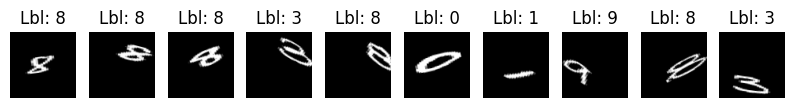

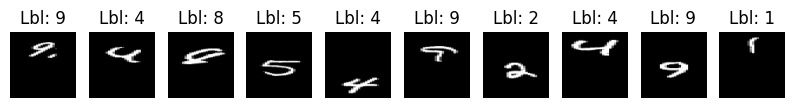

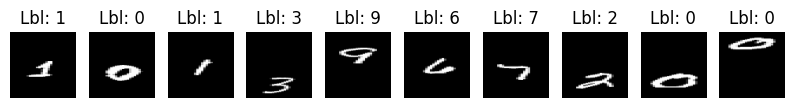

In [9]:
datset_peek(training_generator, 10)
datset_peek(validation_generator, 10)
datset_peek(test_generator, 10)

In [11]:
# trying TensorBoard which will be a callback to an external callback that writes a log file for us to visualize
# I'm not sure a directory check is needed here, but it's a good habit to get into
if os.path.exists(log_dir) is not True:
        os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# make sure your generator can generate 'steps_per_epoch * epochs' batches

# we will adjust the steps per epoch based on the extreme_training flag
steps_per_epoch_bias = 100
if extreme_training:
        steps_per_epoch_bias = 50
        
training_steps_per_epoch = training_generator.samples // batch_size // steps_per_epoch_bias
validation_steps_per_epoch = validation_generator.samples // batch_size // steps_per_epoch_bias
test_steps_per_epoch = test_generator.samples // batch_size // steps_per_epoch_bias

print('training samples:', training_generator.samples)
print('validation samples:', validation_generator.samples)

print('batch_size:', batch_size)

print('planned epochs:', planned_epochs)
print('training steps per epoch:', training_steps_per_epoch)
print('validation steps per epoch:', validation_steps_per_epoch)
print('test steps per epoch:', test_steps_per_epoch)


# model training time and we'll hold on to history for visualization
history = model.fit(
        training_generator,
        steps_per_epoch=training_steps_per_epoch,
        validation_data=validation_generator,
        validation_steps=validation_steps_per_epoch,
        epochs=planned_epochs,
        verbose=1,
        callbacks=[tensorboard_callback])

# Evaluate the model on the test data using `evaluate`
accuracy = model.evaluate(validation_generator, steps=validation_steps_per_epoch, verbose=1)
print('Test accuracy on base model: ', accuracy)


training samples: 192000
validation samples: 48000
batch_size: 32
planned epochs: 20
training steps per epoch: 120
validation steps per epoch: 30
test steps per epoch: 37
Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.7274 - loss: 0.8343 - val_accuracy: 0.8552 - val_loss: 0.4904
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.7269 - loss: 0.7809 - val_accuracy: 0.8438 - val_loss: 0.4819
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.7334 - loss: 0.7893 - val_accuracy: 0.8771 - val_loss: 0.4234
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.7646 - loss: 0.7244 - val_accuracy: 0.8656 - val_loss: 0.4443
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.7638 - loss: 0.7305 - val_accuracy: 0.8875 - val_loss: 0.3500
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.7565 - loss: 0.7500 - val_accuracy: 0.9115 - val_loss: 0.3172
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - 

# Task 8 - Fine-tune the CNN model using appropriate techniques like hyperparameter tuning, cross-validation, etc

## <b>References</b>
vibhu. (Dec 21, 2022). Optimizers in Tensorflow. Available online at: https://www.geeksforgeeks.org/optimizers-in-tensorflow/ [accessed Aug 19, 2024]

In [12]:
# This is a fairly manual, yet procedural iteration through the hyperparameters to find the best model

overall_accuracy = []
# --------------------------------------------------------------------------
# this function will track the accuracy of the model and the hyperparameters used to achieve it
def accuracy_tracker(iteration_num, accuracy, dropout_1, dropout_2, density, optimizer):
    overall_accuracy.append(
        [accuracy[1], accuracy[0], iteration_num, dropout_1, dropout_2, density, optimizer]
    )


# hyperparameter tuning - last variation is the base model which reached 87% accuracy on test / 96% on validation
dropout_1_variations = [0.1, 0.15, 0.2, 0.25]
dropout_2_variations = [0.3, 0.4, 0.5, 0.5]
density_variations = [32, 64, 128, 256]
optimizer_variations = ['adam', 'rmsprop', 'adamax', 'adam']
iteration_sessions = 0

if long_hyperp_training:
    # loop through the variations and train the model - permutation approach of the hyperparameters
    print('extreme training method for hyperparameter tuning')
    print(f'session count: {iteration_sessions}, ')
    for dropout_1 in dropout_1_variations:
        for dropout_2 in dropout_2_variations:
            for density in density_variations:
                for optimizer in optimizer_variations:
                    model = create_model(dropout=dropout_1, dropout_2=dropout_2, density=density, optimizer=optimizer)
                    print('------------------------------------------------------')
                    print(f'session count: {iteration_sessions}, dropout 1: {dropout_1}, dropout 2: {dropout_2}, density: {density}, optimizer: {optimizer}')
                    history = model.fit(
                        training_generator,
                        steps_per_epoch=training_steps_per_epoch,
                        validation_data=validation_generator,
                        validation_steps=validation_steps_per_epoch,
                        epochs=planned_epochs,
                        verbose=1,
                        callbacks=[tensorboard_callback])
                    iteration_sessions += 1
                    accuracy = model.evaluate(test_generator, steps=test_steps_per_epoch, verbose=1)
                    accuracy_tracker(iteration_sessions, accuracy, dropout_1, dropout_2, density, optimizer)
else:
    # iterate once through variations to get a feel for the best model
    print('quick feel method for hyperparameter tuning')
    for index, dropout_1 in enumerate(dropout_1_variations):
        model = create_model(dropout=dropout_1_variations[index], dropout_2=dropout_2_variations[index], density=density_variations[index], optimizer=optimizer_variations[index])
        print('------------------------------------------------------')
        print(f'session count: {iteration_sessions}, dropout 1: {dropout_1_variations[index]}, dropout 2: {dropout_2_variations[index]}, density: {density_variations[index]}, optimizer: {optimizer_variations[index]}')
        history = model.fit(
            training_generator,
            steps_per_epoch=training_steps_per_epoch,
            validation_data=validation_generator,
            validation_steps=validation_steps_per_epoch,
            epochs=planned_epochs,
            verbose=1,
            callbacks=[tensorboard_callback])
        iteration_sessions += 1
        accuracy = model.evaluate(test_generator, steps=test_steps_per_epoch, verbose=1)
        accuracy_tracker(iteration_sessions, accuracy, dropout_1_variations[index], dropout_2_variations[index], density_variations[index], optimizer=optimizer_variations[index])

        print('DONE!')


quick feel method for hyperparameter tuning
------------------------------------------------------
session count: 0, dropout 1: 0.1, dropout 2: 0.3, density: 32, optimizer: adam
Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.1122 - loss: 2.3015 - val_accuracy: 0.1865 - val_loss: 2.2689
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.1408 - loss: 2.2612 - val_accuracy: 0.2865 - val_loss: 1.9777
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.2724 - loss: 2.0134 - val_accuracy: 0.4625 - val_loss: 1.6456
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.3205 - loss: 1.8386 - val_accuracy: 0.4323 - val_loss: 1.6393
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.3550 - loss: 1.7840 - val_accuracy: 0.5646 - val_loss: 1.3348
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.3907 - loss: 1.6792 - val_accuracy: 0.5708 - val_loss: 1.3402
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/

In [13]:
# now find the optimal hyperparameters by looking through the accuracy list
# sort the accuracy list and print the top 5
overall_accuracy.sort(reverse=True)
print('Top models:')
for i in range(4):
    print(f'Accuracy: {overall_accuracy[i][0]:2f} | Loss: {overall_accuracy[i][1]:2f} - Iteration: {overall_accuracy[i][2]} - Dropout 1: {overall_accuracy[i][3]} - Dropout 2: {overall_accuracy[i][4]} - Density: {overall_accuracy[i][5]} - Optimizer: {overall_accuracy[i][6]}')


Top models:
Accuracy: 0.849662 | Loss: 0.492943 - Iteration: 4 - Dropout 1: 0.25 - Dropout 2: 0.5 - Density: 256 - Optimizer: adam
Accuracy: 0.823480 | Loss: 0.551041 - Iteration: 1 - Dropout 1: 0.1 - Dropout 2: 0.3 - Density: 32 - Optimizer: adam
Accuracy: 0.822635 | Loss: 0.591209 - Iteration: 2 - Dropout 1: 0.15 - Dropout 2: 0.4 - Density: 64 - Optimizer: rmsprop
Accuracy: 0.764358 | Loss: 0.815234 - Iteration: 3 - Dropout 1: 0.2 - Dropout 2: 0.5 - Density: 128 - Optimizer: adamax


# Task 9 - Visualize the dataset and the CNN model's results where applicable with feature maps, learning curves, etc

## <b>References</b>
TensorFlow. (Oct 25, 2023). Get started with TensorBoard | TensorFlow. Available online at: https://www.tensorflow.org/tensorboard/get_started. [Accessed Aug 20, 2024] 

Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 0.1505 - loss: 2.2683 - val_accuracy: 0.3021 - val_loss: 1.8853
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.2621 - loss: 1.9627 - val_accuracy: 0.5771 - val_loss: 1.3110
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.4070 - loss: 1.6883 - val_accuracy: 0.6198 - val_loss: 1.2007
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.4909 - loss: 1.4246 - val_accuracy: 0.6833 - val_loss: 0.9388
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.5629 - loss: 1.2471 - val_accuracy: 0.7312 - val_loss: 0.8496
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.5936 - loss: 1.2015 - val_accuracy: 0.7333 - val_loss: 0.7962
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.6342 - loss: 1.0445 - val_accuracy: 0.7740 - val_loss: 0.6884
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.6393 - loss: 1

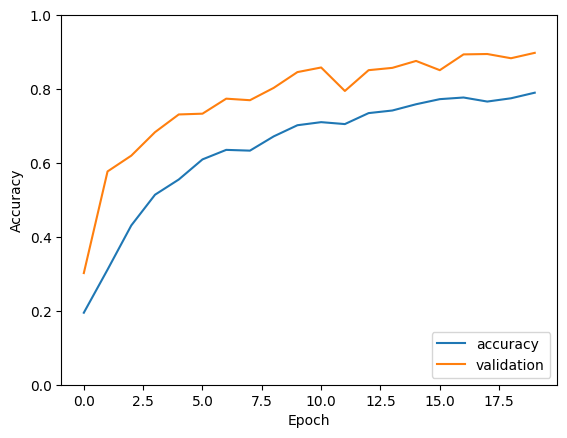

In [14]:
# NOTE: TensorBoard epoch data can be viewed by running the following command in the terminal: tensorboard --logdir=logs
# where the logs directory is written at dataset_root_dir + '\\logs'
# a browser window will open with the TensorBoard data to show how training is proceeding but final model results are also available below

# REFIT & SAVE THE FINAL MODEL
# refit the model with the best possible hyperparameters as determined by the overall_accuracy list
model = create_model(dropout=overall_accuracy[0][3], dropout_2=overall_accuracy[0][4], density=overall_accuracy[0][5], optimizer=overall_accuracy[0][6])
history = model.fit(
    training_generator,
    steps_per_epoch=training_steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps_per_epoch,
    epochs=planned_epochs,
    verbose=1,
    callbacks=[tensorboard_callback])

# --------------------------------------------------------------------------
# this function will plot the training and validation accuracy
def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

# look at our validation accuracy and loss
plot_history(history)

# we're going to save this beautiful model for later use
model.save(dataset_root_dir + '\\models\\mnist_model.keras')

In [ ]:
# NOTE: unfortunately a bug in the current version of TensorFlow/Keras prevents us from using the feature map visualization code below
# Despite the fact the the model was fitted with eager execution it still reports that the sequence has never been called. 
# We even tried doing another fit() and predict() right before the feature_map_model creation but it still says sequence has never been called.
# https://github.com/serengil/deepface/issues/1085

from keras._tf_keras.keras.models import Model

# load the trained model
model_kf = tf.keras.models.load_model(dataset_root_dir + '\\models\\mnist_model.keras')

# load the layers from model
layers = [layer.output for layer in model_kf.layers] 

# setup a feature map model for my layers
feature_map_model = Model(inputs=model_kf.input, outputs=layers)

# Prepare an input image
img_path = dataset_root_dir + '\\triple_mnist\\test\\065\\87_065.png'
feature_maps = feature_map_model.predict(img_path)

# We'll just visualize the feature map of the first layer
first_layer_feature_maps = feature_maps[0]

# Determine the number of feature maps
num_feature_maps = first_layer_feature_maps.shape[-1]

# Set up the figure size
plt.figure(figsize=(20,20))

# Plot each feature map
for i in range(num_feature_maps):
    plt.subplot(8, 8, i+1) # Adjust the grid size according needs
    plt.imshow(first_layer_feature_maps[0, :, :, i], cmap='viridis')
    plt.axis('off')

# Display the feature maps
plt.show()

# Task 10 - Report the final performance of the CNN model using appropriate performance metrics like accuracy, F1-score, etc

In [17]:
from sklearn.metrics import classification_report

# let's setup our true labels and predicted labels
true_labels = test_generator.labels
predicted = model.predict(test_generator, batch_size=batch_size, verbose=1)
predicted_labels = np.argmax(predicted, axis=1)

# Calculate the F1 score
f1_score = classification_report(true_labels, predicted_labels)

# Print the F1 score
print(f1_score)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 46s 24ms/step
              precision    recall  f1-score   support

           0       0.10      0.11      0.11      6300
           1       0.10      0.10      0.10      5800
           2       0.09      0.09      0.09      4900
           3       0.10      0.09      0.10      5800
           4       0.11      0.14      0.13      6600
           5       0.11      0.10      0.10      6700
           6       0.12      0.12      0.12      6500
           7       0.08      0.10      0.09      5000
           8       0.11      0.08      0.09      6700
           9       0.09      0.09      0.09      5700

    accuracy                           0.10     60000
   macro avg       0.10      0.10      0.10     60000
weighted avg       0.10      0.10      0.10     60000



# Task 11 -Decide on the best model for classification and CNN architecture for digital recognition

In [22]:
i=0 # best index
print('Our final best model was a TensorFlow model with the following hyperparameters:')
print(f'Accuracy: {overall_accuracy[i][0]:2f} | Loss: {overall_accuracy[i][1]:2f} - Dropout 1: {overall_accuracy[i][3]} - Dropout 2: {overall_accuracy[i][4]} - Density: {overall_accuracy[i][5]} - Optimizer: {overall_accuracy[i][6]}')
print('------------------------------------------------------')
print(model.summary())
print('------------------------------------------------------')
print('The F1 score for the model is:')
print(f1_score)



Our final best model was a TensorFlow model with the following hyperparameters:
Accuracy: 0.849662 | Loss: 0.492943 - Dropout 1: 0.25 - Dropout 2: 0.5 - Density: 256 - Optimizer: adam
------------------------------------------------------


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 82, 82, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 41, 41, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 39, 39, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 19, 19, 256)    │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 19, 19, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 92416)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │    23,658,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,090,336 (271.19 MB)

 Trainable params: 23,696,778 (90.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,393,558 (180.79 MB)

None
------------------------------------------------------
The F1 score for the model is:
              precision    recall  f1-score   support

           0       0.10      0.11      0.11      6300
           1       0.10      0.10      0.10      5800
           2       0.09      0.09      0.09      4900
           3       0.10      0.09      0.10      5800
           4       0.11      0.14      0.13      6600
           5       0.11      0.10      0.10      6700
           6       0.12      0.12      0.12      6500
           7       0.08      0.10      0.09      5000
           8       0.11      0.08      0.09      6700
           9       0.09      0.09      0.09      5700

    accuracy                           0.10     60000
   macro avg       0.10      0.10      0.10     60000
weighted avg       0.10      0.10      0.10     60000

